# Spatial Error Model

In [1]:
from esda.moran import Moran
import geopandas as gpd
from libpysal.weights import DistanceBand, KNN
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from splot.esda import plot_moran
import spreg
import sys

sys.path.append("..")
from statshelper import q_q_plot
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("../data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


Create a dataframe from the CSV and project it to UTM Zone 16 N.

In [3]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

This is a common set of quantitiative variables shared across all of these models. The method is too memory and computation intensive to use on the whole dataset, so we use a random sample of 2.5%:

In [4]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
other_to_keep = ["PIN", "Neighborhood Code", "Town Code", "geometry"]
my_rows = i_vars+dep_var+other_to_keep
gdf = gdf[my_rows]
gdf = gdf.sample(frac=.025, random_state=0)
print("Dataframe has {} rows and {} columns".format(len(gdf), len(list(gdf.columns))))
X = gdf[i_vars].values
y = gdf[dep_var].values.ravel()
gdf.head()

Dataframe has 8107 rows and 18 columns


,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code,geometry
255476,-1.090298,-0.292681,-0.780196,-0.213234,-0.668786,-0.599533,-0.891279,-2.100215,-0.041762,1.066654,0.082893,-0.268846,-1.233509,-0.213048,27272130250000,46,28,POINT (430474.445 4604029.943)
4525,-0.771854,-0.292681,-0.318133,-0.419435,-1.613855,-0.599533,-0.891279,-2.100215,-0.041762,1.066654,-2.396135,-0.268846,-0.983113,-1.020361,7072031870000,109,35,POINT (406403.875 4657100.302)
206728,-0.899231,2.583133,2.016681,0.949160,0.117826,-0.599533,2.162552,-2.100215,-0.041762,-0.848209,0.955862,2.906338,0.769658,0.771894,28314100050000,210,13,POINT (435165.992 4601377.469)
251208,-0.453411,-0.292681,-0.731985,0.374207,-0.133190,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.596010,-0.795788,-1.358707,-0.086441,12124070110000,10,26,POINT (432372.275 4647115.837)
172553,0.215320,-0.292681,-0.772410,-0.961504,-0.131889,-0.599533,-0.891279,-2.100215,-0.041762,-0.848209,0.302863,-0.795788,-1.483905,-1.267365,23142080080000,12,30,POINT (431836.962 4616704.122)


Create a weight matrix from the geodataframe using k-nearest neighbors.

In [5]:
# determine weight matrix
w = KNN.from_dataframe(gdf, k=64) # needed k large enough that it was connected
#w = DistanceBand.from_dataframe(gdf,threshold=.0075) # needed k large enough that it was connected

Transform the weight matrix to normalize the rows.

In [6]:
w.transform = 'R'

Calculate the Spatial Error Model!

In [7]:
sem = spreg.ML_Error(y, X, w=w, name_x=i_vars, name_y="Sale Price")

/home/lagrange/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [8]:
print(sem.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Sale Price                Number of Observations:        8107
Mean dependent var  :     -0.0035                Number of Variables   :          14
S.D. dependent var  :      0.9999                Degrees of Freedom    :        8093
Pseudo R-squared    :      0.4908
Sigma-square ML     :       0.229                Log likelihood        :   -5649.644
S.E of regression   :       0.478                Akaike info criterion :   11327.289
                                                 Schwarz criterion     :   11425.295

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

**Note that the random subsample may mean that your results vary from this analysis.**

Looking at the `Probability` row we see that the intercept, `Bedrooms`, `Full Baths`, `Garage 2 Area`, and `Rooms` are statistically insignificant. Ignoring these variables, the only variable with a negative coefficient is `Age`, which makes sense.

Taking a quick look at the models' fit:

* Pseudo $R^2$ is 0.49 which is quite low compared to OLS. This means that only 46% of the variation in `Sales Price` can be explained by the model, which isn't good.
* The AIC of 11,327.29 is lower than OLS on the entire dataset, but it is important to note that you cannot directly compare AIC of models on different datasets. 

Next, let's look at the residuals:

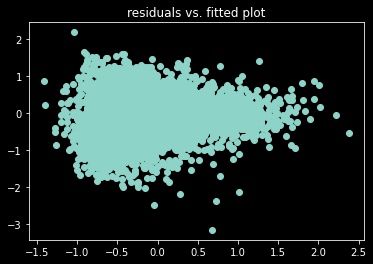

In [9]:
Taking a quick look at the models' fit:

* Pseudo $R^2$ is 0.49 which is quite low compared to OLS. This means that only 46% of the variation in `Sales Price` can be explained by the model, which isn't good.
* The AIC of 11,327.29 is lower than OLS on the entire dataset, but it is important to note that you cannot directly compare AIC of models on different datasets. 

Next, let's look at the residuals:plt.scatter(sem.predy, sem.e_filtered)
plt.title("residuals vs. fitted plot")
plt.show()

Now, we can check if the errors are spatially autocorrelated using the Moran's I and map the residuals:

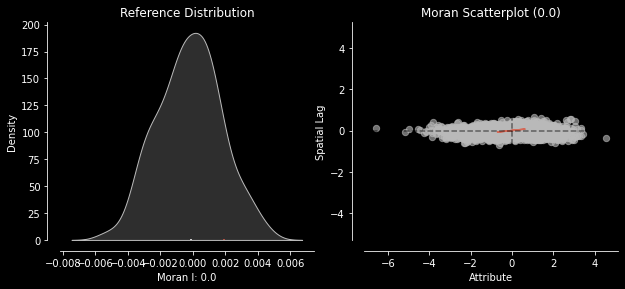

In [10]:
sem_moran = Moran(sem.e_filtered, w, permutations=199)
plot_moran(sem_moran, zstandard=True, figsize=(10,4))
plt.show()

-3.1525923966714435 2.190120829168955


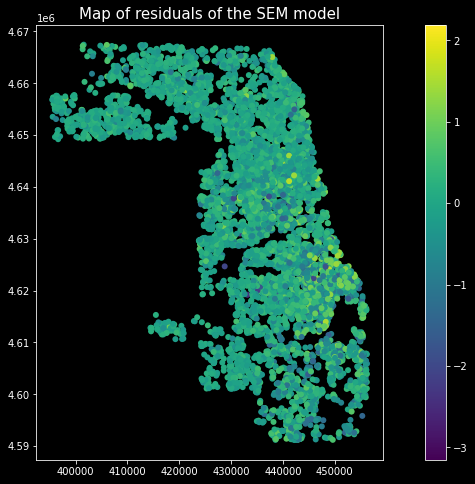

In [11]:
data = sem.e_filtered.reshape(-1)
_min, _max = min(data), max(data)
print(_min, _max)
_width = (_max-_min)
ax = gdf.plot(column=sem.e_filtered.reshape(-1),legend=True,figsize=(15,8), linewidth=0.0)
plt.title("Map of residuals of the SEM model",fontsize=15)
plt.show()

## Results from Subsampling

The dataset is too large to run on even a Slurm cluster (requires ~800GB RAM) so I ran the method on 5% of the data over 100 iterations to get an idea of what the results might be. The results are in `data/results/SpatialErrorModelResult05.csv`.

In [12]:
res = pd.read_csv("../data/results/SpatialErrorModelResult05.csv")
res.head()

,Iteration,AIC,R^2,Moran's I,Age Coefficient,Age Z-Stat,Age Probability,Bedrooms Coefficient,Bedrooms Z-Stat,Bedrooms Probability,...,Half Baths Probability,Land Square Feet Coefficient,Land Square Feet Z-Stat,Land Square Feet Probability,Rooms Coefficient,Rooms Z-Stat,Rooms Probability,Sale Quarter Coefficient,Sale Quarter Z-Stat,Sale Quarter Probability
0,0,22547.157249,0.410357,-0.003449,-1.718361,-17.111276,1.222913e-65,-0.143108,-25.277240,5.684879e-141,...,0.608559,0.019782,4.556034,5.212848e-06,0.101291,11.038099,2.502729e-28,-0.009365,-1.052753,0.292454
1,1,22742.166709,0.424338,-0.001834,-1.550454,-15.917909,4.760192e-57,-0.131531,-22.354865,1.082779e-110,...,0.050790,0.022748,5.146364,2.655845e-07,0.100758,10.701134,1.005403e-26,-0.006831,-0.751841,0.452147
2,2,22887.217112,0.397963,-0.003419,-1.664325,-15.898701,6.469182e-57,-0.140806,-24.867089,1.689739e-136,...,0.119278,0.022048,4.922112,8.561507e-07,0.121887,12.917442,3.588739e-38,-0.008990,-0.990501,0.321929
3,3,22678.749409,0.460319,-0.003906,-1.590500,-16.631343,4.132245e-62,-0.123776,-21.668430,4.074157e-104,...,0.579448,0.021962,4.902519,9.461553e-07,0.084492,8.930121,4.255416e-19,0.001236,0.138080,0.890177
4,4,22472.309344,0.445124,-0.003495,-1.652278,-16.790296,2.874058e-63,-0.129569,-22.464563,9.221404e-112,...,0.544669,0.024203,5.519382,3.401943e-08,0.099607,10.774246,4.554988e-27,0.012345,1.380554,0.167416


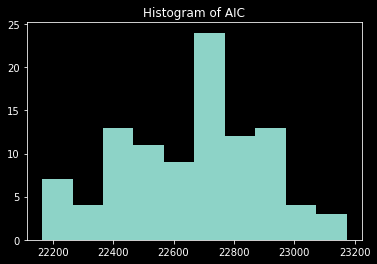

In [13]:
plt.hist(res["AIC"])
plt.title("Histogram of AIC")
plt.show()

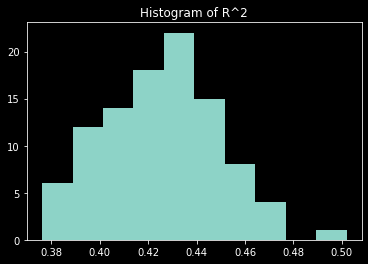

In [14]:
plt.hist(res["R^2"])
plt.title("Histogram of R^2")
plt.show()

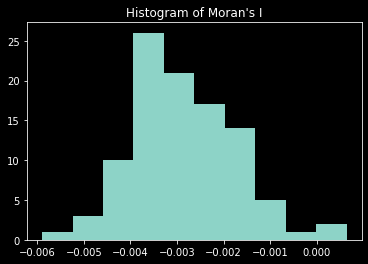

In [15]:
plt.hist(res["Moran's I"])
plt.title("Histogram of Moran's I")
plt.show()

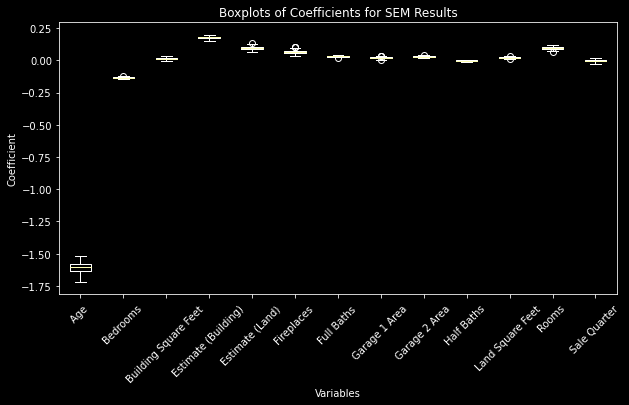

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot([res[column] for column in res.columns if "Coefficient" in column])
ax.set(
    axisbelow=True,
    title="Boxplots of Coefficients for SEM Results",
    xlabel="Variables",
    ylabel="Coefficient"
)
ax.set_xticklabels([column.replace("Coefficient", "") for column in res.columns if "Coefficient" in column], rotation=45)
plt.show()

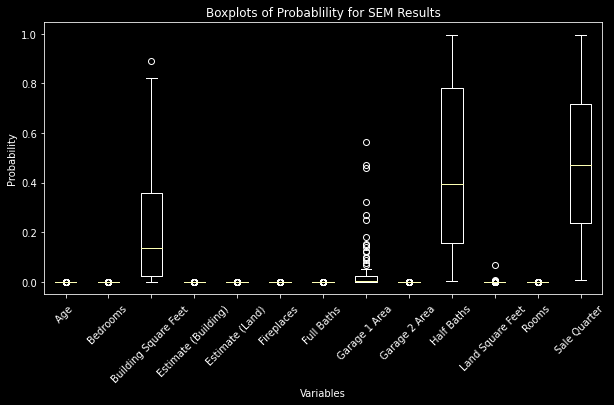

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot([res[column] for column in res.columns if "Probability" in column])
ax.set(
    axisbelow=True,
    title="Boxplots of Probablility for SEM Results",
    xlabel="Variables",
    ylabel="Probability"
)
ax.set_xticklabels([column.replace("Probability", "") for column in res.columns if "Probability" in column], rotation=45)
plt.show()